In [ ]:
!pip install tensorflow==2.16.2


## Many-to-One RNN for Next Word Prediction
### Overview
Recurrent Neural Networks (RNNs) are a class of neural networks that are well-suited for processing sequences of data. In the "many-to-one" architecture of RNNs, a sequence of inputs is processed to produce a single output. This architecture is commonly used for tasks like sentiment analysis, sequence classification, and next word prediction.

![Screenshot 2024-07-07 at 1.08.29 AM.png](<attachment:Screenshot 2024-07-07 at 1.08.29 AM.png>)

### Many-to-One RNN Architecture
In the many-to-one architecture:

- The input is a sequence of elements.
- Each element in the sequence is fed into the RNN one at a time.
- The RNN maintains a hidden state that is updated at each time step.
- After processing the entire sequence, the RNN generates a single output from the final hidden state.

![Screenshot 2024-07-07 at 1.10.05 AM.png](<attachment:Screenshot 2024-07-07 at 1.10.05 AM.png>)
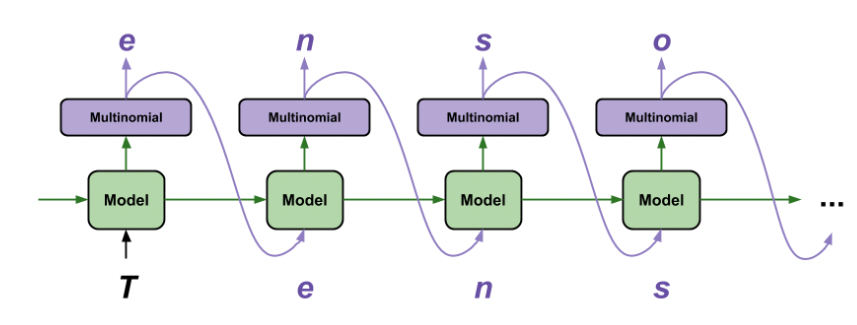
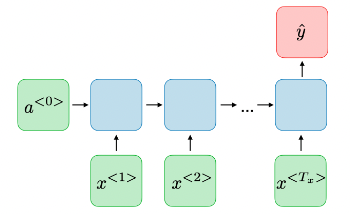

In [ ]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


In [ ]:

data_text  = pd.read_csv('/content/df_commentary_new.csv')

In [ ]:
def data_processing(data,number_of_rows, list_of_columns):
    data = data.drop(columns= list_of_columns,axis=1)
    data = data.head(number_of_rows)
    return data

### Tokenizer
A tokenizer is a tool that converts text into numerical data, making it suitable for input into neural networks. In the context of RNNs, a tokenizer performs the following steps:

- Text Tokenization: Splits text into individual words or tokens.
- Vocabulary Creation: Assigns a unique integer to each word in the vocabulary.
- Sequence Conversion: Converts sequences of words into sequences of integers.


In [ ]:
def tokenize(data):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data['Modified_Commentary'])
    return tokenizer

### Input Sequence
The input sequence is a series of numerical tokens that represent words in the text. These sequences are typically padded to ensure uniform length, which is necessary for batch processing in neural networks.



In [ ]:
def input_sequences(data):
  input_sequences = []
  for i in range(len(data_text['Modified_Commentary'])):
      text = data_text['Modified_Commentary'][i]
      token_list = tokenizer.texts_to_sequences([text])[0]
      for i in range(1, len(token_list)):
          n_gram_sequence = token_list[:i+1]
          input_sequences.append(n_gram_sequence)

  max_len = max(len(x) for x in input_sequences)

  return input_sequences, max_len


In [23]:
max_len = max(len(x) for x in input_sequences)
max_len

153

In [ ]:
### Calling all the functions

dropped_columns = ['Unnamed: 0']
data_text =  data_processing(data_text, 1000, dropped_columns)
tokenizer  = tokenize(data_text)
input_sequences, max_len = input_sequences(data_text)
padded_input_sequences = pad_sequences(input_sequences, maxlen=max_len + 1, padding='pre')
padded_input_sequences
x = padded_input_sequences[:, :-1]
y = padded_input_sequences[:, -1]
y = to_categorical(y, num_classes=len(tokenizer.word_index)+1)
print('x shape : ',{x.shape})
print('x shape : ',{y.shape})


x shape :  {(45086, 153)}
x shape :  {(45086, 3583)}


In [ ]:

# print maximum word index

max_word_index = max([index for word, index in tokenizer.word_index.items()])
print(f"Maximum word index: {max_word_index}")

# print max length each string

max_length = data_text['Modified_Commentary'].str.len().max()

print(f"Maximum length of a string: {max_length}")

max_text_index = data_text[data_text['Modified_Commentary'].str.len() == max_length].index[0]

print(f"Index of maximum length of a string: {max_text_index}")


Maximum word index: 3582
Maximum length of a string: 798
Index of maximum length of a string: 325


### Building the RNN Encoder:
The RNN encoder processes the input sequence and captures its context in a fixed-size vector.
We use an Embedding layer to convert word indices into dense vectors, and SimpleRNN layers to process these vectors.

### Training the RNN Model:
Training involves feeding the model with input sequences and their corresponding next words and adjusting the model weights to minimize prediction error.
We use categorical cross-entropy as the loss function and the Adam optimizer for efficient training.
Batch size and validation set:
- Batch size determines the number of samples processed before the model weights are updated. Common batch sizes are 32, 64, or 128.
- A validation set, separate from the training data, is used to monitor the model's performance during training and prevent overfitting.


In [ ]:
def rnn_model():

  model_rnn = Sequential()
  model_rnn.add(Embedding(input_dim=3583, output_dim= 100, input_length=max_len))
  model_rnn.add(SimpleRNN(100, return_sequences=True)) # Pass return_sequences to LSTM
  model_rnn.add(SimpleRNN(100))
  model_rnn.add(Dense(3583, activation='softmax'))
  model_rnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model_rnn


In [ ]:
model = rnn_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(x,y,epochs= 50)

## With accuracy of 50 percent

In [ ]:

eval_data = data_text.iloc[-5:]
eval_sequences = tokenizer.texts_to_sequences(eval_data['Modified_Commentary'])
max_predict_len = 10

# Function to predict the next n words
def predict_next_n_words(model, tokenizer, seed_text, n_words):
    result = []
    for _ in range(n_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_len, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=1)[0]
        predicted_word = tokenizer.index_word[predicted_index]
        result.append(predicted_word)
        seed_text += ' ' + predicted_word
    return result

# Evaluate the model
reverse_word_index = dict((i, word) for word, i in tokenizer.word_index.items())
for i, seq in enumerate(eval_sequences):
    if len(seq) > 10:
        first_10_words = seq[:10]
    else:
        first_10_words = seq

    first_10_words_text = ' '.join(reverse_word_index.get(word, '?') for word in first_10_words)
    predicted_words = predict_next_n_words(model, tokenizer, first_10_words_text, max_predict_len)
    actual_next_10_words = seq[10:20] if len(seq) > 20 else seq[10:]
    actual_next_10_words_text = ' '.join(reverse_word_index.get(word, '?') for word in actual_next_10_words)

    print(f"Sentence {i+1}:")
    print(f"First 10 words: {first_10_words_text}")
    print(f"Actual next 10 words: {actual_next_10_words_text}")
    print(f"Predicted next 10 words: {' '.join(predicted_words)}")
    print()








Sentence 1:
First 10 words: out caught by uthappa umesh yadav strikes and removes the
Actual next 10 words: big fish he bowled much better compared to his first
Predicted next 10 words: big fish he bowled a little shimmy down the track

Sentence 2:
First 10 words: four that's harsh on the bowler that didn't deserve to
Actual next 10 words: go to the boundary it was banged in short and
Predicted next 10 words: go to the boundary mohit moves across and swishes it

Sentence 3:
First 10 words: four welcome to delhi says iyer shortish and wide outside
Actual next 10 words: off iyer treks back and fiercely cuts it behind square
Predicted next 10 words: off iyer treks back and fiercely cuts it behind square

Sentence 4:
First 10 words: out caught by billings zak attack strikes trap set and
Actual next 10 words: trap sprung so batsman's promotion fails lasted for just two
Predicted next 10 words: trap sprung so batsman's promotion fails lasted for a strategic

Sentence 5:
First 10 words: four 

In [ ]:
model.fit(x,y,epochs=1)

1409/1409 ━━━━━━━━━━━━━━━━━━━━ 171s 121ms/step - accuracy: 0.7960 - loss: 0.7946


In [ ]:
from tensorflow.keras.models import load_model, save_model

In [ ]:
save_model(model, 'model_rnn_1.keras')


## With model accuracy of 90 percent

In [ ]:
model.fit(x,y,epochs=15)

In [ ]:

eval_data = data_text.iloc[-5:]
eval_sequences = tokenizer.texts_to_sequences(eval_data['Modified_Commentary'])
max_predict_len = 10

# Function to predict the next n words
def predict_next_n_words(model, tokenizer, seed_text, n_words):
    result = []
    for _ in range(n_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_len, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)
        predicted_index = np.argmax(predicted_probs, axis=1)[0]
        predicted_word = tokenizer.index_word[predicted_index]
        result.append(predicted_word)
        seed_text += ' ' + predicted_word
    return result

# Evaluate the model
reverse_word_index = dict((i, word) for word, i in tokenizer.word_index.items())
for i, seq in enumerate(eval_sequences):
    if len(seq) > 10:
        first_10_words = seq[:10]
    else:
        first_10_words = seq

    first_10_words_text = ' '.join(reverse_word_index.get(word, '?') for word in first_10_words)
    predicted_words = predict_next_n_words(model, tokenizer, first_10_words_text, max_predict_len)
    actual_next_10_words = seq[10:20] if len(seq) > 20 else seq[10:]
    actual_next_10_words_text = ' '.join(reverse_word_index.get(word, '?') for word in actual_next_10_words)

    print(f"Sentence {i+1}:")
    print(f"First 10 words: {first_10_words_text}")
    print(f"Actual next 10 words: {actual_next_10_words_text}")
    print(f"Predicted next 10 words: {' '.join(predicted_words)}")
    print()










### Degradation of Scores with Longer Sequences:
- As sequence length increases, model performance typically degrades due to difficulty in capturing long-term dependencies.
- Attention mechanisms address this by allowing the model to focus on relevant parts of the input sequence when making predictions.


## Problem's with RNN

#### 1.  Vanishing and Exploding Gradients
##### Vanishing Gradients
- Issue: During backpropagation, gradients can become extremely small, effectively preventing the network from learning long-range dependencies.
- Impact: This makes it difficult for RNNs to learn from long sequences since the influence of an earlier input gradually diminishes as it propagates through the network.
##### Exploding Gradients
- Issue: Conversely, gradients can also become extremely large, leading to unstable updates and divergence during training.
- Impact: This can result in the model failing to converge or producing wildly fluctuating predictions.
#### 2. Long-Term Dependencies
- Issue: RNNs struggle to maintain information over long sequences due to the vanishing gradient problem.
- Impact: This limits the ability of standard RNNs to capture long-term dependencies within the data, which is crucial for many sequence-based tasks.
#### 3. Slow Training and Inference
- Issue: RNNs require sequential processing of inputs, meaning that computations cannot be parallelized as easily as in feedforward networks.
- Impact: This leads to longer training and inference times, making RNNs less efficient for large-scale or real-time applications.
#### 4. Limited Memory Capacity
- Issue: Standard RNNs have a limited capacity to store information, which can be problematic when dealing with complex sequences that require remembering long-term context.
- Impact: This restricts their effectiveness in tasks requiring substantial memory of previous inputs.
#### 5. Difficulty in Handling Variable-Length Sequences
- Issue: While RNNs can handle sequences of varying lengths, managing these variations in practice (e.g., padding, truncating) can introduce complexity and inefficiency.
- Impact: Handling variable-length sequences often requires additional preprocessing and careful handling during training and inference.